# Dataset
The data is taken from the kaggle datasets. Link: https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018
The data was originally published on the UCI Machine Learning repository. It is the same data, but it is converted from tsv file into csv file in this 2018 kaggle hackathon version. We will use this dataset for sentiment analysis as a classification task. As in the description of the event we will try to answer the question:
 -  What elements of a review make it more helpful to others? Which patients tend to have more negative reviews? Can you determine if a review is positive, neutral, or negative?

## Motivation
We will apply a basic task in sentiment analysis which is classifying the polarity of a given text (review). Our motivation for selecting this dataset is; 
1. There are concrete preprocessing steps for the text data. 
2. Using the tf-idf representation of the reviews, we can get high dimensional data and we can use the same represenation to visualize using techniques PCA, LLE and t-SNE

In this step we will look into the data in general and decide which preprocessing steps should we take into account.

In [4]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("drugsCom_raw/drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("drugsCom_raw/drugsComTest_raw.csv", parse_dates=["date"])

In [5]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [6]:
df_train['review'].replace('"', '', regex=True, inplace=True)
df_test['review'].replace('"', '', regex=True, inplace=True)

In [7]:
df_train.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,2010-04-27,192
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,2016-11-27,37
5,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,2015-11-28,43
6,165907,Levonorgestrel,Emergency Contraception,"He pulled out, but he cummed a bit in me. I to...",1,2017-03-07,5
7,102654,Aripiprazole,Bipolar Disorde,Abilify changed my life. There is hope. I was ...,10,2015-03-14,32
8,74811,Keppra,Epilepsy,I Ve had nothing but problems with the Keppe...,1,2016-08-09,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,I had been on the pill for many years. When my...,8,2016-12-08,1


In [9]:
df_train.shape

(161297, 7)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uniqueID     161297 non-null  int64         
 1   drugName     161297 non-null  object        
 2   condition    160398 non-null  object        
 3   review       161297 non-null  object        
 4   rating       161297 non-null  int64         
 5   date         161297 non-null  datetime64[ns]
 6   usefulCount  161297 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 8.6+ MB


In [12]:
df_train.condition.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorder', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorder', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cancer',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia',

The only missing value is in condition column. In order to answer which patients tend to give negative reviews, we need the condition data. We can say the patient who uses X drug tend to give negative reviews, but in which condition? So, we will drop missing rows since it is relatively small proportion of the data.

By visually controlling the problems in condition column. We can see there are lots of html span tag which doesn't indicate any condition. We will also drop these rows if they are not too many to impact our dataset. 

There are also some spelling errors for the words 'cance': 'cancer' and 'disorde':'disorder'. These spelling errors seem to happen at the end of the text. So we will correct them.

In [13]:
df_train.loc[df_train.condition.isna()]

,uniqueID,drugName,condition,review,rating,date,usefulCount
30,51452,Azithromycin,NaN,Very good response. It is so useful for me.,10,2010-08-18,1
148,61073,Urea,NaN,Accurate information.,10,2011-07-02,13
488,132651,Doxepin,NaN,So far so good. Good for me and I can take it ...,10,2010-10-20,25
733,44297,Ethinyl estradiol / norgestimate,NaN,I haven&#039;t been on it for a long time and ...,8,2011-01-24,1
851,68697,Medroxyprogesterone,NaN,I started the shot in July 2015 and ended in J...,6,2017-03-23,1
...,...,...,...,...,...,...,...
160468,117817,Multivitamin with minerals,NaN,Severe hives itching after taking for 6 months,5,2015-11-15,0
160500,657,Medroxyprogesterone,NaN,I am 18 and I have been using the shot for 8 m...,6,2011-11-20,2
160689,104844,Ethinyl estradiol / levonorgestrel,NaN,I&#039;ve been on Loseasonique for about 2 wee...,10,2010-04-13,3
160752,41252,Acetaminophen / oxycodone,NaN,This is my third day using this pain medicine....,10,2010-12-13,4


In [14]:
df_train.loc[df_train.condition.str.contains(r'<.+?>', case=False, na=False, regex=True).values]

,uniqueID,drugName,condition,review,rating,date,usefulCount
105,220696,Loestrin 24 Fe,2</span> users found this comment helpful.,I&#039;m 16 and I have been on Loestrin 24 fo...,3,2010-11-03,2
196,67383,Provera,4</span> users found this comment helpful.,I&#039;m 24 years old and have always had a pr...,1,2016-03-27,4
243,81588,Yaz,3</span> users found this comment helpful.,I took Yaz for a little over 2 years. From ar...,3,2010-06-01,3
264,132965,Loestrin 24 Fe,4</span> users found this comment helpful.,Took this pill for 1.) Acne and 2.) Birth Cont...,2,2014-06-24,4
391,91050,Norco,11</span> users found this comment helpful.,I have suffered with low back pain - 2 surgeri...,9,2009-03-15,11
...,...,...,...,...,...,...,...
160322,173464,Alli,99</span> users found this comment helpful.,Great pill... You can definitely see it workin...,9,2015-04-02,99
160791,150010,Soma,62</span> users found this comment helpful.,I am sharing a painful experience actually. Th...,5,2010-03-11,62
160899,209239,Geodon,7</span> users found this comment helpful.,I&#039;ve been taking Geodon for about a month...,7,2011-02-04,7
160921,96527,Neurontin,92</span> users found this comment helpful.,At 300mg 4x daily my pain was almost gone.,9,2013-07-08,92


Since they are not too many, we will remove them from the dataset. Also we can see some parsing problems in review column. Such as;

- I\&#039;m : I'm
- I\&#039;ve : I'have

This problem can be solved using html parser on review column.

In [15]:
import html

df_train['review'] = df_train['review'].map(lambda x: html.unescape(x))

In [16]:
df_train.loc[df_train.condition.str.contains(r'<.+?>', case=False, na=False, regex=True).values]

,uniqueID,drugName,condition,review,rating,date,usefulCount
105,220696,Loestrin 24 Fe,2</span> users found this comment helpful.,I'm 16 and I have been on Loestrin 24 for abo...,3,2010-11-03,2
196,67383,Provera,4</span> users found this comment helpful.,I'm 24 years old and have always had a pretty ...,1,2016-03-27,4
243,81588,Yaz,3</span> users found this comment helpful.,I took Yaz for a little over 2 years. From ar...,3,2010-06-01,3
264,132965,Loestrin 24 Fe,4</span> users found this comment helpful.,Took this pill for 1.) Acne and 2.) Birth Cont...,2,2014-06-24,4
391,91050,Norco,11</span> users found this comment helpful.,I have suffered with low back pain - 2 surgeri...,9,2009-03-15,11
...,...,...,...,...,...,...,...
160322,173464,Alli,99</span> users found this comment helpful.,Great pill... You can definitely see it workin...,9,2015-04-02,99
160791,150010,Soma,62</span> users found this comment helpful.,I am sharing a painful experience actually. Th...,5,2010-03-11,62
160899,209239,Geodon,7</span> users found this comment helpful.,I've been taking Geodon for about a month or s...,7,2011-02-04,7
160921,96527,Neurontin,92</span> users found this comment helpful.,At 300mg 4x daily my pain was almost gone.,9,2013-07-08,92


### Check if reviews contain html-like tags

In [17]:
df_train.loc[df_train.review.str.contains(r'<.+?>', case=False, na=False, regex=True).values]

,uniqueID,drugName,condition,review,rating,date,usefulCount
15174,18181,Ethinyl estradiol / etonogestrel,Birth Control,I was on this for 5 years (and birth control p...,7,2011-06-17,0
83776,127253,Melatonin,Insomnia,Just took my melatonin. Currently can't stop y...,6,2015-11-11,26


In [18]:
df_train.loc[15174, "review"]

"I was on this for 5 years (and birth control pills for about 12 years), and would have told you how fabulous it was.  <List all the benefits everyone else has listed, here.>  Then a friend of mine convinced me to stop birth control all together for a while, and I turned into a new and better person!  I dropped 5 lbs instantly, had a huge sex drive, more lubrication, and just felt better.  I wouldn't say I was depressed before, but after going off of it, I would describe my time on birth control as feeling like I was inside a cloud.  Less emotions in general, sometimes a little down.  I'm bummed I'm back on it, but it seems to be the least impactful than the others.  I might try Paragard to avoid the hormones."

In [19]:
df_train.loc[83776, "review"]

"Just took my melatonin. Currently can't stop yawning while scrolling through reading about all the awesome sleeps you guys had.. <yawns> still can't sleep tho.. "

### Check if reviews contain any emoji characters

In [58]:
import emoji

In [64]:
(df_train["review"].map(lambda x: bool(emoji.get_emoji_regexp().search(x)))).any()

True

In [72]:
df_emoji = df_train.loc[df_train["review"].map(lambda x: bool(emoji.get_emoji_regexp().search(x))).values]
df_emoji

,uniqueID,drugName,condition,review,rating,date,usefulCount
117,49143,Ethinyl estradiol / levonorgestrel,Birth Control,I love Lutera. I am very sensitive to other fo...,9,2016-07-29,10
3615,49127,Ethinyl estradiol / levonorgestrel,Birth Control,Hi Ladies I wanted to share my experience with...,10,2016-08-05,4
5079,27222,Imitrex,Migraine,Lifesaver! This med has helped give me my life...,10,2017-05-22,4
5630,138267,Orthovisc,Osteoarthritis,I had these injections two years ago in my ri...,10,2016-09-29,31
7087,112111,Gabapentin,ibromyalgia,The only reason I haven't rated this drug high...,7,2017-05-17,22
...,...,...,...,...,...,...,...
145934,57064,MiraLax,Constipation,It worked!! Relief took 12 hours but it was ge...,10,2016-07-22,40
147460,148461,Mirena,Birth Control,My #1 prayer is that someone will read this BE...,1,2017-07-08,12
152740,85056,Ethinyl estradiol / norgestimate,Acne,I started taking TriNessa 3wks ago to help wit...,1,2015-12-07,5
155925,122769,Linaclotide,Irritable Bowel Syndrome,37 yr old f..Suffered with ibsc going on 2y no...,10,2015-02-07,15


In [73]:
df_train.loc[117, "review"]

'I love Lutera. I am very sensitive to other forms of birth control. Lutera has been one of the only kinds I can take. \r\r\nPros: light periods, no cramping, no intense side effects, bigger boobs.\r\r\nCons: Brown periods, slight weight gain. \r\r\nI also tend to get a bit emotional 1 or 2 days before my period....however I am always an emotional person so this could just be me. I have been on Lutera for 6 years ☺'

In [74]:
df_train.loc[3615, "review"]

"Hi Ladies I wanted to share my experience with this orsythia pill. Well I have now been takin it for about 5 months and I Love it. I was on the nexplanon for 6 months before I changed it to the pill. And it was the worst so many symptoms like headaches and nausea and always so hungry. When i had my son I was weighting at 200 pounds before I had him and lost 30 when I gave birth so I was down to 170. I tried my hardest to loose weight with the nexplanon after inserting it after giving birth. I dieted well eating 1,200 or less calories a day doing 3 hours of workout and nothing. Right when I switched to the pill I started losing weight rapidly I was at 170 and now I'm at 142 in less than 4 months and I havnt been as hungry❤"

# Preprocessing

In [126]:
# Read from scratch
df_train = pd.read_csv("drugsCom_raw/drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("drugsCom_raw/drugsComTest_raw.csv", parse_dates=["date"])

# Remove double quotes from reviews
df_train['review'].replace('"', '', regex=True, inplace=True)
df_test['review'].replace('"', '', regex=True, inplace=True)

In [128]:
# Correct misspelling for visually detected two words in condition column
df_train["condition"].replace(to_replace=r'(?i)disorde$', value='Disorder', regex=True, inplace=True)
df_train["condition"].replace(to_replace=r'(?i)cance$', value='Cancer', regex=True, inplace=True)

df_test["condition"].replace(to_replace=r'(?i)disorde$', value='Disorder', regex=True, inplace=True)
df_test["condition"].replace(to_replace=r'(?i)cance$', value='Cancer', regex=True, inplace=True)

In [129]:
# Drop rows with condition column is NaN
df_train.dropna(subset=['condition'], inplace=True)
df_train.drop(index=df_train.loc[df_train.condition.str.contains(r'<.+?>', case=False, na=False, regex=True).values].index, inplace=True)

In [131]:
import re

# Remove html tag-like part from previously seen two record.
df_train.loc[15174, "review"] = re.sub(r'<.+?>', "", df_train.loc[15174, "review"], flags=re.IGNORECASE)
df_train.loc[83776, "review"] = re.sub(r'<.+?>', "", df_train.loc[83776, "review"], flags=re.IGNORECASE)

In [154]:
# Expand contractions using a dictionary
def expand_contractions(s):
    contractions_dict = {"ain’t": "are not", "’s": " is", "aren’t": "are not", "can’t": "cannot",
                         "can’t’ve": "cannot have", "‘cause": "because", "could’ve": "could have",
                         "couldn’t": "could not", "couldn’t’ve": "could not have", "didn’t": "did not",
                         "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
                         "hasn’t": "has not", "haven’t": "have not", "he’d": "he would", "he’d’ve": "he would have",
                         "he’ll": "he will", "he’ll’ve": "he will have", "how’d": "how did", "how’d’y": "how do you",
                         "how’ll": "how will", "I’d": "I would", "I’d’ve": "I would have", "I’ll": "I will",
                         "I’ll’ve": "I will have", "I’m": "I am", "I’ve": "I have", "isn’t": "is not",
                         "it’d": "it would", "it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have",
                         "let’s": "let us", "ma’am": "madam", "mayn’t": "may not", "might’ve": "might have",
                         "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have",
                         "mustn’t": "must not", "mustn’t’ve": "must not have", "needn’t": "need not",
                         "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not",
                         "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not",
                         "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have",
                         "she’ll": "she will", "she’ll’ve": "she will have", "should’ve": "should have",
                         "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have",
                         "that’d": "that would", "that’d’ve": "that would have", "there’d": "there would",
                         "there’d’ve": "there would have", "they’d": "they would", "they’d’ve": "they would have",
                         "th’ll": "they will", "they’ll’ve": "they will have", "they’re": "they are",
                         "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would",
                         "we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have",
                         "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
                         "what’ll’ve": "what will have", "what’re": "what are", "what’ve": "what have",
                         "when’ve": "when have", "where’d": "where did", "where’ve": "where have",
                         "who’ll": "who will", "who’ll’ve": "who will have", "who’ve": "who have",
                         "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",
                         "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have",
                         "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have",
                         "y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would",
                         "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
                         "you’re": "you are", "you’ve": "you have",

                         "ain't": "are not", "'s": " is", "aren't": "are not", "can't": "cannot",
                         "can't've": "cannot have", "'cause": "because", "could've": "could have",
                         "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
                         "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
                         "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have",
                         "he'll": "he will", "he'll've": "he will have", "how'd": "how did", "how'd'y": "how do you",
                         "how'll": "how will", "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                         "I'll've": "I will have", "I'm": "I am", "I've": "I have", "isn't": "is not",
                         "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                         "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                         "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
                         "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                         "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
                         "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                         "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                         "she'll": "she will", "she'll've": "she will have", "should've": "should have",
                         "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                         "that'd": "that would", "that'd've": "that would have", "there'd": "there would",
                         "there'd've": "there would have", "they'd": "they would", "they'd've": "they would have",
                         "th'll": "they will", "they'll've": "they will have", "they're": "they are",
                         "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
                         "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                         "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                         "what'll've": "what will have", "what're": "what are", "what've": "what have",
                         "when've": "when have", "where'd": "where did", "where've": "where have",
                         "who'll": "who will", "who’ll've": "who will have", "who've": "who have",
                         "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                         "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                         "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
                         "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
                         "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                         "you're": "you are", "you've": "you have"}

    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    def replace(match):
        return contractions_dict[match.group(0)]

    return contractions_re.sub(replace, s)

In [168]:
import html
import emoji
from string import punctuation
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer


def clean_lines(review):
    lines = list(filter(lambda l: l != '', review.splitlines()))
    return ' '.join(lines)

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
    
def multiple_preprocessing_steps(review):
    
    
    # Fix parsing errors
    review = html.unescape(review)
    # Demojize
    review = emoji.demojize(review)
    # Deal with newlines and splitlines
    review = clean_lines(review)
    # Expand contractions
    review = expand_contractions(review)
    
    # Remove spaces from begin and end
    review = review.strip()
    
    # Before removing punctuations change possible signs into words
    review = re.sub('\$', " dollar ", review)
    review = re.sub('\%', " percent ", review)
    review = re.sub('\&', " and ", review)
    
    # Remove punctuations
    review = review.translate(review.maketrans(punctuation, ' ' * len(punctuation)))
    
    # Tokenize
    tokens = nltk.word_tokenize(review)
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]

    # Lower
    tokens = [w.lower() for w in tokens]

    # Get the tokens with 2 or more letters
    review = " ".join([w for w in tokens if (len(w) > 1)])
    
    return review

In [169]:
df_train['review'] = df_train['review'].map(lambda r: multiple_preprocessing_steps(r))
df_test['review'] = df_test['review'].map(lambda r: multiple_preprocessing_steps(r))

In [170]:
df_train

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,it have no side effect take it in combination ...,9,2012-05-20,27
1,95260,Guanfacine,ADHD,my son be halfway through his fourth week of i...,8,2010-04-27,192
2,92703,Lybrel,Birth Control,use to take another oral contraceptive which h...,5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,this be my first time use any form of birth co...,8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone have completely turn my life around f...,9,2016-11-27,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,write my first report in mid october of 2014 h...,10,2015-05-31,125
161293,127085,Metoclopramide,Nausea/Vomiting,be give this in iv before surgey immediately b...,1,2011-11-01,34
161294,187382,Orencia,Rheumatoid Arthritis,limited improvement after month developed bad ...,2,2014-03-15,35
161295,47128,Thyroid desiccated,Underactive Thyroid,have be on thyroid medication 49 year spent my...,10,2015-09-19,79


In [171]:
# We will treat reviews with rating above 5 as positive review and negative if their rating is below or equal to 5
df_train['sentiment'] = df_train["rating"].apply(lambda x: 1 if x > 5 else 0)

In [172]:
df_test['sentiment'] = df_test["rating"].apply(lambda x: 1 if x > 5 else 0)

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159498 entries, 0 to 159497
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     159498 non-null  int64 
 1   drugName     159498 non-null  object
 2   condition    159498 non-null  object
 3   review       159491 non-null  object
 4   rating       159498 non-null  int64 
 5   date         159498 non-null  object
 6   usefulCount  159498 non-null  int64 
 7   sentiment    159498 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 9.7+ MB


In [16]:
df_train = df_train.dropna()

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uniqueID     53766 non-null  int64 
 1   drugName     53766 non-null  object
 2   condition    53471 non-null  object
 3   review       53763 non-null  object
 4   rating       53766 non-null  int64 
 5   date         53766 non-null  object
 6   usefulCount  53766 non-null  int64 
 7   sentiment    53766 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 3.3+ MB


In [18]:
df_test = df_test.dropna(subset=['review'])

In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53763 entries, 0 to 53765
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uniqueID     53763 non-null  int64 
 1   drugName     53763 non-null  object
 2   condition    53468 non-null  object
 3   review       53763 non-null  object
 4   rating       53763 non-null  int64 
 5   date         53763 non-null  object
 6   usefulCount  53763 non-null  int64 
 7   sentiment    53763 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 3.7+ MB


In [20]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [21]:
# df_train.to_csv('drugsCom_raw/train.csv', index=False)

In [22]:
# df_test.to_csv('drugsCom_raw/test.csv', index=False)

# Models and Performances

In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("drugsCom_raw/train.csv")
df_test = pd.read_csv("drugsCom_raw/test.csv")

In [2]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,it have no side effect take it in combination ...,9,2012-05-20,27,1
1,95260,Guanfacine,ADHD,my son be halfway through his fourth week of i...,8,2010-04-27,192,1
2,92703,Lybrel,Birth Control,use to take another oral contraceptive which h...,5,2009-12-14,17,0
3,138000,Ortho Evra,Birth Control,this be my first time use any form of birth co...,8,2015-11-03,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone have completely turn my life around f...,9,2016-11-27,37,1


In [3]:
# Features
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(ngram_range=(1, 1), max_features=5000)

X_train, y_train = df_train.review.values, df_train.sentiment.values
X_test, y_test = df_test.review.values, df_test.sentiment.values

target_names = ["negatief", "positief"]

In [4]:
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.fit_transform(X_test).toarray()

In [5]:
X_train.shape

(159491, 5000)

In [6]:
X_test.shape

(53763, 5000)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from datetime import datetime

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf, model_name):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax = sns.heatmap(conf_matrix, cmap="Blues", annot=True, fmt="d", linewidths=.5)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(f"{model_name} confusion matrix, without normalization")
    # fig.savefig(name + '_CM.eps', format='eps')
    ax.xaxis.set_ticklabels(['negative', 'positive']); 
    ax.yaxis.set_ticklabels(['negative', 'positive']);
    plt.show()



Model: LinearSVC

Accuracy %: 64.74
              precision    recall  f1-score   support

    negatief       0.37      0.23      0.28     16207
    positief       0.71      0.83      0.77     37556

    accuracy                           0.65     53763
   macro avg       0.54      0.53      0.52     53763
weighted avg       0.61      0.65      0.62     53763



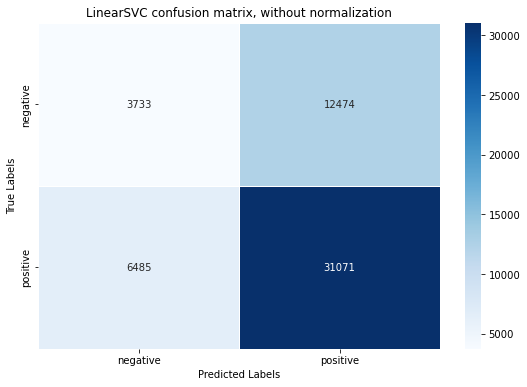

In [ ]:
random_state = 42

models = [
    LinearSVC(penalty='l2', C=1, max_iter=1000, random_state=random_state),
    SVC(C=1, kernel='rbf', gamma='scale', class_weight='balanced', random_state=random_state),
    RandomForestClassifier(n_estimators=200, max_depth=3, class_weight='balanced', random_state=random_state),
    XGBClassifier(n_jobs=1, use_label_encoder=False, tree_method='hist', predictor='cpu_predictor', 
                  learning_rate=0.3, max_depth=6, min_child_weight=1, gamma=0, random_state=random_state)
]

cv_df = pd.DataFrame(index=range(len(models)))

performances = []

for model in models:
    model_name = model.__class__.__name__
    t0 = datetime.now()
    model.fit(X_train, y_train)
    train_time = datetime.now() - t0

    t1 = datetime.now()
    y_pred = model.predict(X_test)
    test_time = datetime.now() - t1
    
    accuracy = accuracy_score(y_test, y_pred)
    performances.append((model_name, accuracy))
    cls_report = classification_report(y_test, y_pred, target_names=target_names)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\n===========================================================\n")
    print(f"Model: {model_name}\n")
    print(f"Accuracy %: {round(accuracy*100, 2)}")
    print(cls_report)
    plot_confusion_matrix(conf_matrix, model_name)
    
cv_df = pd.DataFrame(performances, columns=['model_name', 'accuracy'])

In [ ]:
cv_df.to_csv("cv_df.csv", index=False)